In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
import pandas as pd

In [ ]:
%load_ext autoreload
%autoreload 2
from utils import set_seed, create_metric_plots
from main import train_model
from loader import load_data_set, collact_batch, preprocess_review

/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/datasets/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprec

In [ ]:
set_seed(42)

In [ ]:
BATCH_SIZE = 64
MAX_LEN = 100
EMBEDDING_DIM = 100
INPUT_DIM = EMBEDDING_DIM
REVIEW_LEN = 100
OUTPUT_DIM = 2

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Data

In [ ]:
data = pd.read_csv("IMDB Dataset.csv")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df = data.copy()
# Add a column with the length of each review
df['review_length'] = df['review'].apply(lambda x: len(x)/5)

# Sort the DataFrame by review length
sorted_df = df.sort_values(by='review_length', ascending=True)

,review,sentiment,review_length
27521,"Read the book, forget the movie!",negative,6.4
31072,"What a script, what a story, what a mess!",negative,8.2
40817,I hope this group of film-makers never re-unites.,negative,9.8
28920,Primary plot!Primary direction!Poor interpreta...,negative,10.2
19874,This movie is terrible but it has some good ef...,negative,10.4
...,...,...,...
5708,**Attention Spoilers**<br /><br />First of all...,positive,2072.6
31436,"Back in the mid/late 80s, an OAV anime by titl...",positive,2425.8
31240,"(Some spoilers included:)<br /><br />Although,...",positive,2586.0
40521,There's a sign on The Lost Highway that says:<...,positive,2597.6


In [ ]:
%load_ext autoreload
%autoreload 2
from torch.utils.data import DataLoader
import loader
import importlib

importlib.reload(loader)

train_data, test_data = load_data_set(load_my_reviews=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collact_batch)

In [ ]:
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE,
                             shuffle=False, collate_fn=collact_batch)

# Models

## RNN

In [ ]:

class RNN(nn.Module):
    def __init__(self, feature_dim=EMBEDDING_DIM, state_dim=64, class_dim=OUTPUT_DIM):
        super(RNN, self).__init__()
        self.state_dim = state_dim
        self.input_to_hidden = nn.Linear(feature_dim + state_dim, state_dim)
        self.hidden_to_output = nn.Linear(state_dim, class_dim)
        self.layer_norm = nn.LayerNorm(state_dim)
        self.initialize_weights()

    def initialize_weights(self):
        nn.init.xavier_uniform_(self.input_to_hidden.weight)
        nn.init.xavier_uniform_(self.hidden_to_output.weight)

    def forward(self, inputs, hidden):
        batch_size, seq_length, _ = inputs.size()

        for t in range(seq_length):
            input_t = inputs[:, t, :].to(device)
            combined = torch.cat((input_t, hidden), dim=1)
            hidden = self.layer_norm(torch.tanh(self.input_to_hidden(combined)))

        logits = self.hidden_to_output(hidden)
        return logits, hidden

    def name(self):
        return "RNN"

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.state_dim)

    def train_step(self, inputs, targets, optimizer, criterion):
        optimizer.zero_grad()
        hidden = self.init_hidden(inputs.size(0)).to(inputs.device)
        logits, hidden = self(inputs, hidden)
        loss = criterion(logits, targets)
        loss.backward()

        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)

        optimizer.step()
        return loss.item(), logits

    def validation_step(self, inputs, targets, criterion):
        with torch.no_grad():
            hidden = self.init_hidden(inputs.size(0)).to(inputs.device)
            logits, hidden = self(inputs, hidden)
            loss = criterion(logits, targets)
        return loss.item(), logits



Epoch 1/5
Training RNN on cuda:0


Epoch 1/5 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating RNN on cuda:0


Epoch 1/5 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.7005, Train Accuracy: 0.5214
Test Loss: 0.6871, Test Accuracy: 0.5484

Epoch 2/5
Training RNN on cuda:0


Epoch 2/5 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating RNN on cuda:0


Epoch 2/5 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.6965, Train Accuracy: 0.5337
Test Loss: 0.6871, Test Accuracy: 0.5487

Epoch 3/5
Training RNN on cuda:0


Epoch 3/5 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating RNN on cuda:0


Epoch 3/5 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.6844, Train Accuracy: 0.5502
Test Loss: 0.6911, Test Accuracy: 0.5295

Epoch 4/5
Training RNN on cuda:0


Epoch 4/5 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating RNN on cuda:0


Epoch 4/5 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.6902, Train Accuracy: 0.5422
Test Loss: 0.6940, Test Accuracy: 0.5129

Epoch 5/5
Training RNN on cuda:0


Epoch 5/5 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating RNN on cuda:0


Epoch 5/5 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.6881, Train Accuracy: 0.5500
Test Loss: 0.6818, Test Accuracy: 0.5537


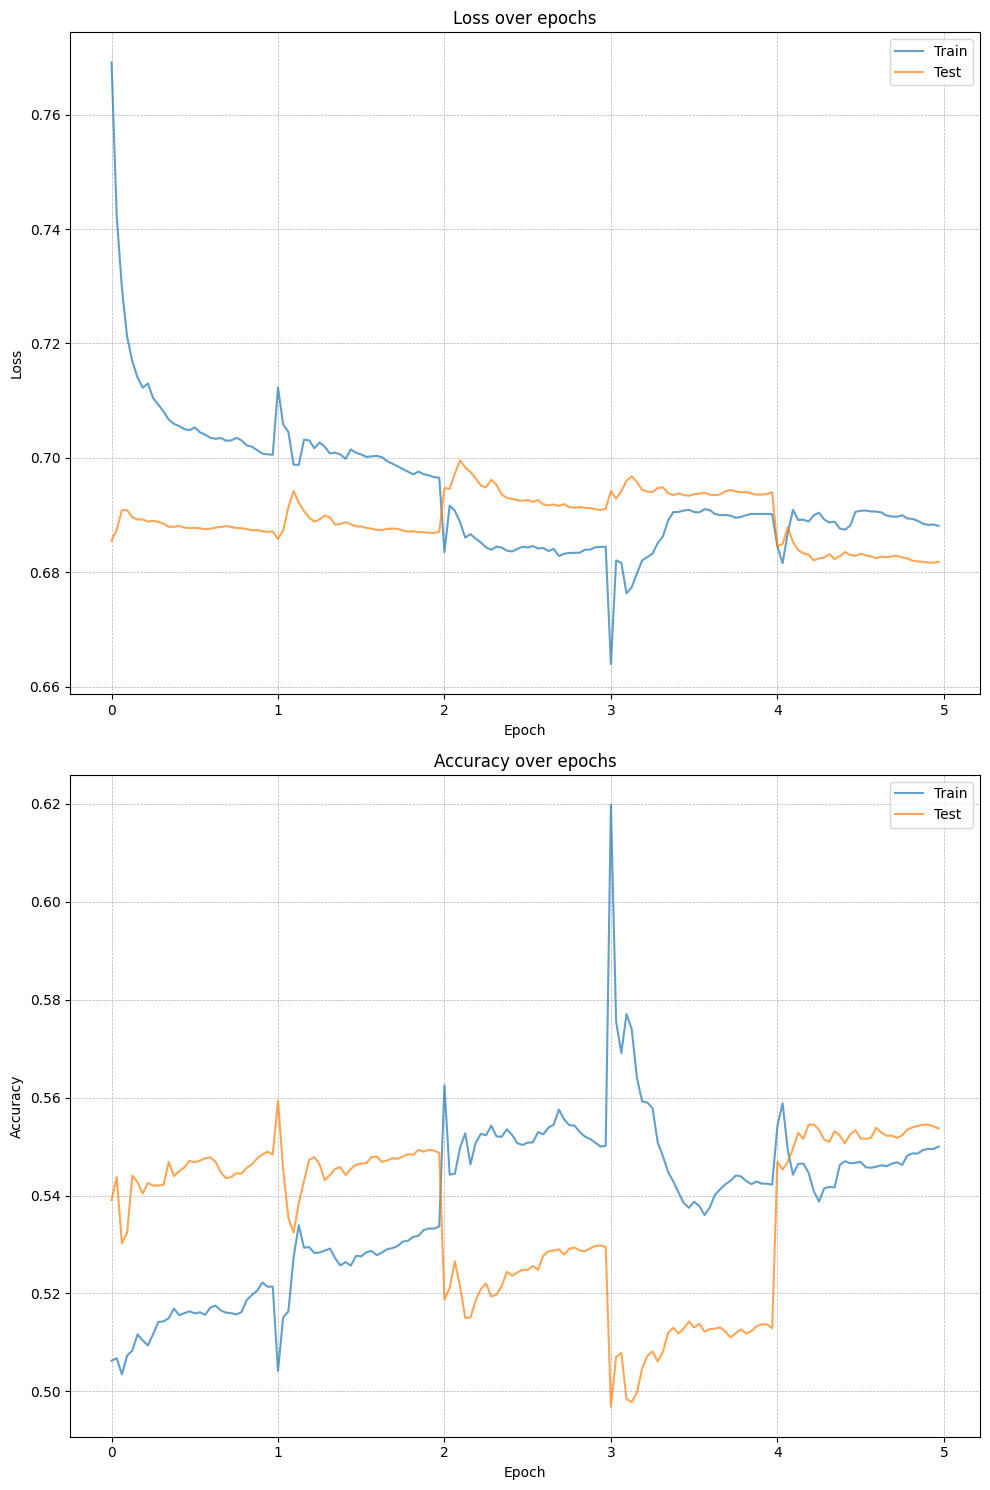

In [ ]:
rnn64 = RNN(state_dim=64).to(device)
rnn64_metrics = train_model(rnn64, train_dataloader, test_dataloader,
                          optimizer=torch.optim.Adam(rnn64.parameters(), lr=0.005),
                          criterion=nn.CrossEntropyLoss(),
                          num_epochs=5)


Epoch 1/5
Training RNN on cuda:0


Epoch 1/5 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating RNN on cuda:0


Epoch 1/5 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.7161, Train Accuracy: 0.5111
Test Loss: 0.6909, Test Accuracy: 0.5236

Epoch 2/5
Training RNN on cuda:0


Epoch 2/5 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating RNN on cuda:0


Epoch 2/5 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.7013, Train Accuracy: 0.5292
Test Loss: 0.7162, Test Accuracy: 0.5024

Epoch 3/5
Training RNN on cuda:0


Epoch 3/5 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating RNN on cuda:0


Epoch 3/5 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.6970, Train Accuracy: 0.5248
Test Loss: 0.6882, Test Accuracy: 0.5425

Epoch 4/5
Training RNN on cuda:0


Epoch 4/5 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating RNN on cuda:0


Epoch 4/5 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.6990, Train Accuracy: 0.5290
Test Loss: 0.6883, Test Accuracy: 0.5535

Epoch 5/5
Training RNN on cuda:0


Epoch 5/5 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating RNN on cuda:0


Epoch 5/5 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.6970, Train Accuracy: 0.5276
Test Loss: 0.7023, Test Accuracy: 0.5030


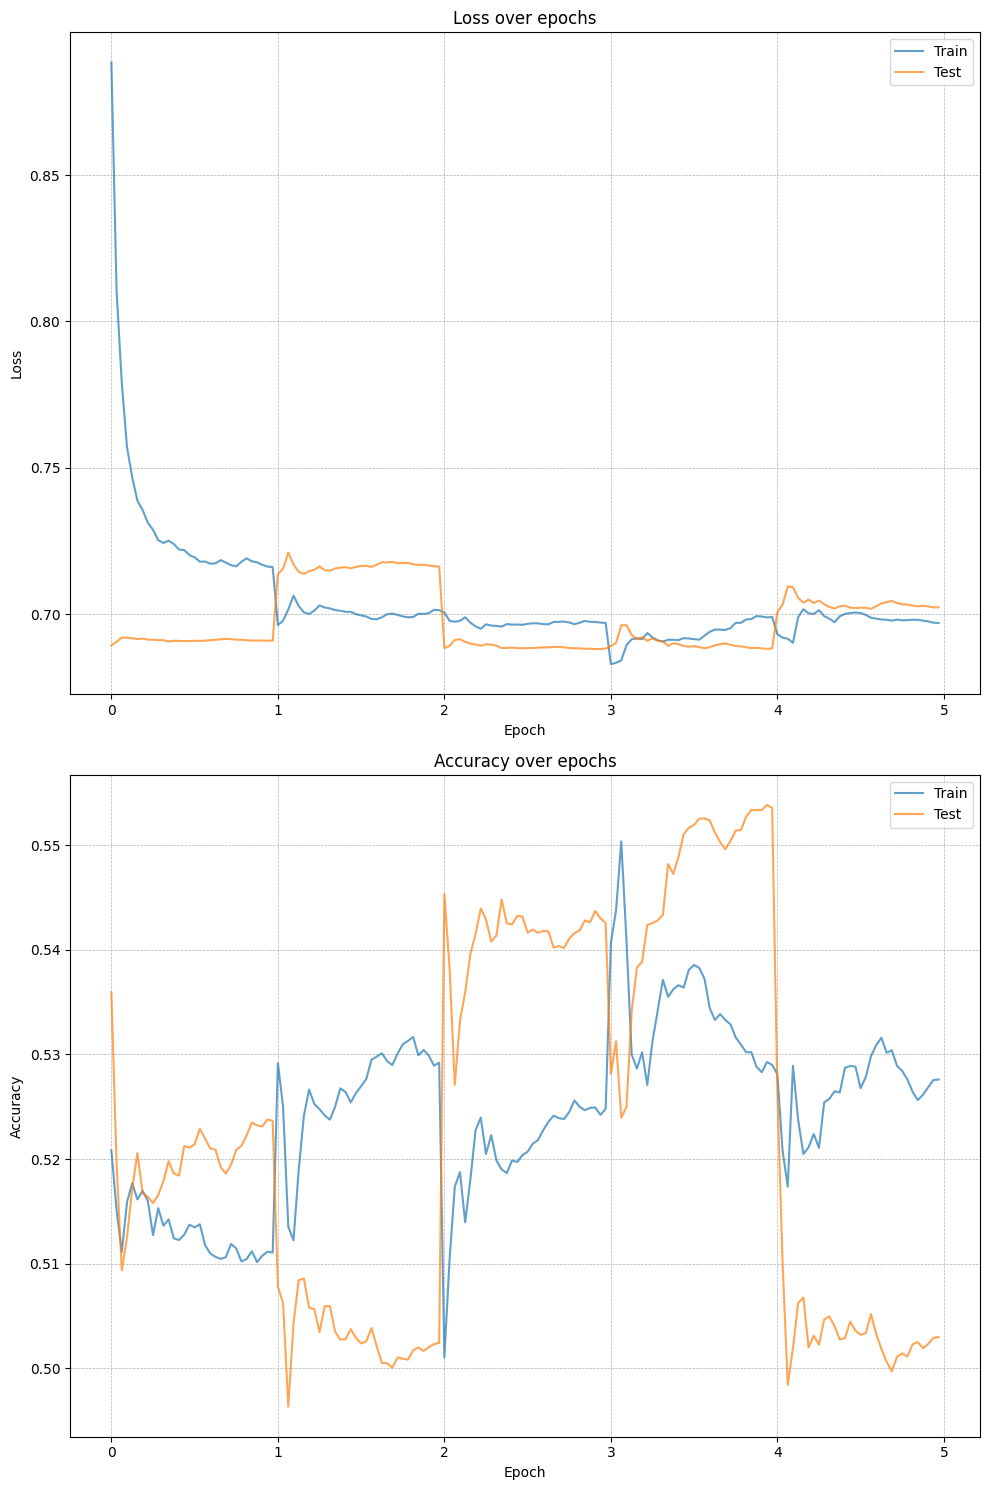

In [ ]:
rnn128 = RNN(state_dim=128).to(device)
rnn128_metrics = train_model(rnn128, train_dataloader, test_dataloader,
                          optimizer=torch.optim.Adam(rnn128.parameters(), lr=0.005),
                          criterion=nn.CrossEntropyLoss(),
                          num_epochs=5)

## GRU


In [ ]:


class ExGRU(nn.Module):
    def __init__(self, feature_dim=EMBEDDING_DIM, state_dim=64, class_dim=OUTPUT_DIM):
        super(ExGRU, self).__init__()
        self.state_dim = state_dim
        self.update_gate = nn.Linear(feature_dim + state_dim, state_dim)
        self.reset_gate = nn.Linear(feature_dim + state_dim, state_dim)
        self.fc = nn.Linear(feature_dim + state_dim, state_dim)
        self.hidden_to_output = nn.Linear(state_dim, class_dim)
        self.layer_norm = nn.LayerNorm(state_dim)
        self.initialize_weights()

    def initialize_weights(self):
        nn.init.xavier_uniform_(self.update_gate.weight)
        nn.init.xavier_uniform_(self.reset_gate.weight)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.xavier_uniform_(self.hidden_to_output.weight)

    def forward(self, inputs, hidden):
        batch_size, seq_length, _ = inputs.size()
        for t in range(seq_length):
            input_t = inputs[:, t, :].to(device)
            combined = torch.cat((input_t, hidden), dim=1)
            zt = torch.sigmoid(self.update_gate(combined))
            rt = torch.sigmoid(self.reset_gate(combined))
            mid = hidden * rt
            combined_mid = torch.cat((input_t, mid), dim=1)
            h_hat = torch.tanh(self.fc(combined_mid))
            hidden = ((1 - zt) * hidden) + (zt * h_hat)
            hidden = self.layer_norm(hidden)

        logits = self.hidden_to_output(hidden)
        return logits, hidden

    def name(self):
        return "GRU"

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.state_dim)

    def train_step(self, inputs, targets, optimizer, criterion):
        optimizer.zero_grad()
        hidden = self.init_hidden(inputs.size(0)).to(inputs.device)
        logits, hidden = self(inputs, hidden)
        loss = criterion(logits, targets)
        loss.backward()

        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)

        optimizer.step()
        return loss.item(), logits

    def validation_step(self, inputs, targets, criterion):
        with torch.no_grad():
            hidden = self.init_hidden(inputs.size(0)).to(inputs.device)
            logits, hidden = self(inputs, hidden)
            loss = criterion(logits, targets)
        return loss.item(), logits



Epoch 1/5
Training GRU on cuda:0


Epoch 1/5 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating GRU on cuda:0


Epoch 1/5 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.5721, Train Accuracy: 0.7018
Test Loss: 0.4617, Test Accuracy: 0.7841

Epoch 2/5
Training GRU on cuda:0


Epoch 2/5 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating GRU on cuda:0


Epoch 2/5 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.4708, Train Accuracy: 0.7787
Test Loss: 0.4238, Test Accuracy: 0.8042

Epoch 3/5
Training GRU on cuda:0


Epoch 3/5 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating GRU on cuda:0


Epoch 3/5 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.4401, Train Accuracy: 0.7993
Test Loss: 0.4758, Test Accuracy: 0.7649

Epoch 4/5
Training GRU on cuda:0


Epoch 4/5 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating GRU on cuda:0


Epoch 4/5 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.4307, Train Accuracy: 0.8057
Test Loss: 0.4491, Test Accuracy: 0.7980

Epoch 5/5
Training GRU on cuda:0


Epoch 5/5 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating GRU on cuda:0


Epoch 5/5 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.4153, Train Accuracy: 0.8134
Test Loss: 0.4500, Test Accuracy: 0.8015


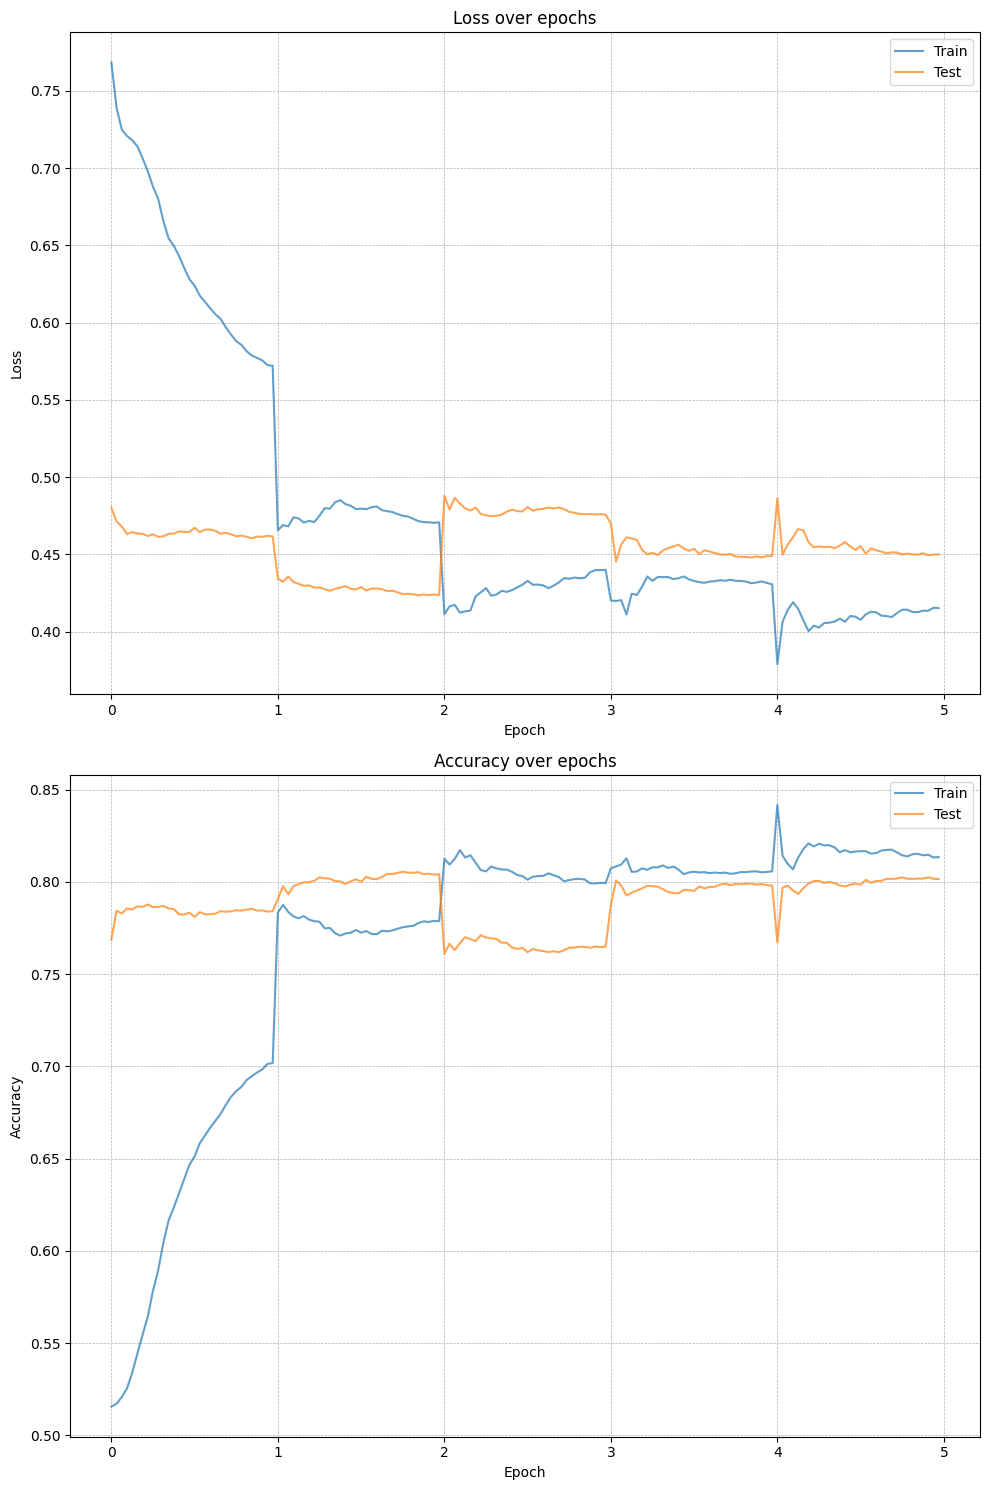

In [ ]:
gru64 = ExGRU(state_dim=64).to(device)
gru64_metrics = train_model(gru64, train_dataloader, test_dataloader,
                          optimizer=torch.optim.Adam(gru64.parameters(), lr=0.005),
                          criterion=nn.CrossEntropyLoss(),
                          num_epochs=4)


Epoch 1/5
Training GRU on cuda:0


Epoch 1/5 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating GRU on cuda:0


Epoch 1/5 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.6031, Train Accuracy: 0.6796
Test Loss: 0.4777, Test Accuracy: 0.7711

Epoch 2/5
Training GRU on cuda:0


Epoch 2/5 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating GRU on cuda:0


Epoch 2/5 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.4961, Train Accuracy: 0.7651
Test Loss: 0.4740, Test Accuracy: 0.7690

Epoch 3/5
Training GRU on cuda:0


Epoch 3/5 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating GRU on cuda:0


Epoch 3/5 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.4773, Train Accuracy: 0.7789
Test Loss: 0.6161, Test Accuracy: 0.6914

Epoch 4/5
Training GRU on cuda:0


Epoch 4/5 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating GRU on cuda:0


Epoch 4/5 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.4485, Train Accuracy: 0.7926
Test Loss: 0.4741, Test Accuracy: 0.7732

Epoch 5/5
Training GRU on cuda:0


Epoch 5/5 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating GRU on cuda:0


Epoch 5/5 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.4284, Train Accuracy: 0.8034
Test Loss: 0.4165, Test Accuracy: 0.8058


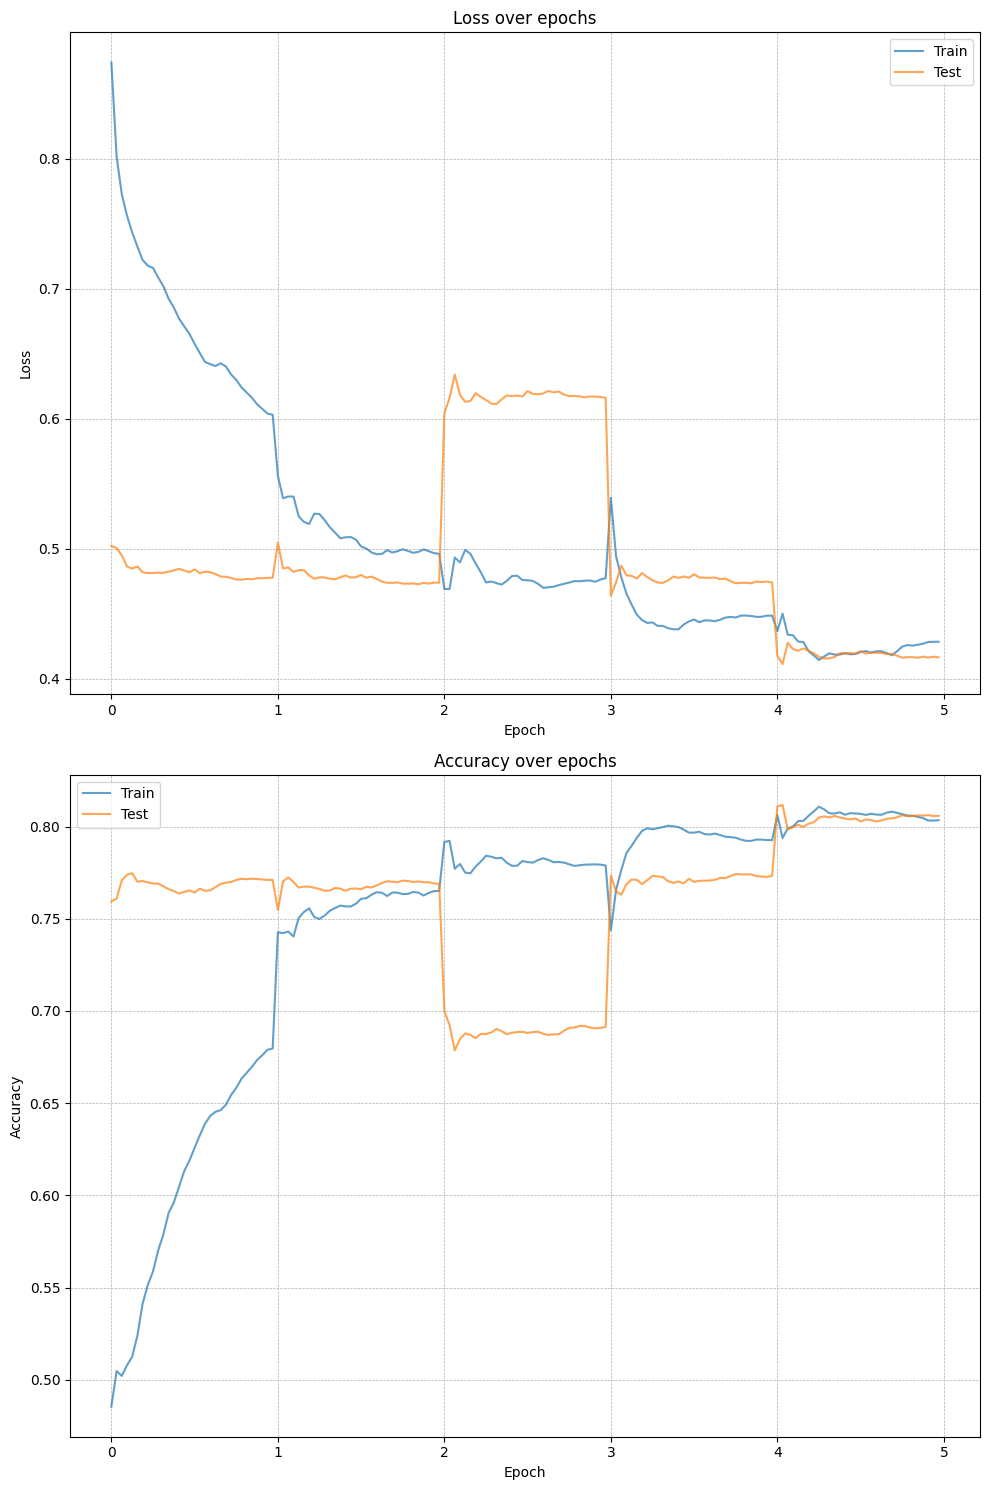

In [ ]:
gru128 = ExGRU(state_dim=128).to(device)
gru128_metrics = train_model(gru128, train_dataloader, test_dataloader,
                          optimizer=torch.optim.Adam(gru128.parameters(), lr=0.005),
                          criterion=nn.CrossEntropyLoss(),
                          num_epochs=4)

# save models

In [ ]:
#torch.save(rnn64, rnn64.name() + '_64'+ ".pth")

In [ ]:
#torch.save(rnn128, rnn128.name() + '_128'+ ".pth")

In [ ]:
#torch.save(gru64, gru64.name() + '_64'+ ".pth")

In [ ]:
#torch.save(gru128, gru128.name() + '_128'+ ".pth")

In [ ]:
held_out_reviews = [
    # Positive Reviews
    "This movie was amazing, truly a masterpiece!",
    "I enjoyed every moment of this fantastic film.",
    "The actors delivered outstanding performances, loved it.",
    "Great storyline and excellent direction, highly recommend it.",
    "I wasn't looking forward to watching the film. I was surprised I enjoyed it very much.",

    # Negative Reviews
    "This movie was boring and uninteresting.",
    "I did not enjoy the film at all.",
    "Terrible acting and weak storyline, very disappointing.",
    "Poor direction and lackluster performances, avoid it.",
    "it is hard being that good in being so bad."
]


# test models

In [ ]:
model = torch.load("/content/RNN_64.pth", map_location=device)
model.eval()

sent_list = []
for s in held_out_reviews:
    preprocessed_review = loader.preprocess_review(s)
    preprocessed_review = preprocessed_review.to(device)  # Reassign to device
    hidden = model.init_hidden(1).to(device)

    with torch.no_grad():
        output, hidden = model(preprocessed_review, hidden)
        probs = torch.softmax(output, dim=1)  # Convert logits to probabilities
        _, predicted = torch.max(probs, 1)  # Get the index of the max probability
        sent_list.append('pos' if predicted.item() == 0 else 'neg')

sent_list


['pos', 'neg', 'pos', 'pos', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg']

In [ ]:
model = torch.load("/content/RNN_128.pth", map_location=device)
model.eval()

sent_list = []
for s in held_out_reviews:
    preprocessed_review = loader.preprocess_review(s)
    preprocessed_review = preprocessed_review.to(device)  # Reassign to device
    hidden = model.init_hidden(1).to(device)

    with torch.no_grad():
        output, hidden = model(preprocessed_review, hidden)
        probs = torch.softmax(output, dim=1)  # Convert logits to probabilities
        _, predicted = torch.max(probs, 1)  # Get the index of the max probability
        sent_list.append('pos' if predicted.item() == 0 else 'neg')

sent_list


['pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos']

In [ ]:
model = torch.load("/content/GRU_64.pth", map_location=device)
model.eval()
sent_list  = []
for s in held_out_reviews:
  preprocessed_review = loader.preprocess_review(s)
  preprocessed_review.to(device)
  hidden = torch.zeros(1, model.state_dim).to(device)
  with torch.no_grad():
      output, hidden = model(preprocessed_review, hidden)
      probs = torch.softmax(output, dim=1)  # Convert logits to probabilities
      _, predicted = torch.max(probs, 1)  # Get the index of the max probability
      sent_list.append( 'pos' if predicted.item() == 0 else 'neg')
sent_list

['pos', 'pos', 'pos', 'pos', 'pos', 'neg', 'pos', 'neg', 'neg', 'pos']

In [ ]:
model = torch.load("/content//GRU_128.pth", map_location=device)
model.eval()
sent_list  = []
for s in held_out_reviews:
  preprocessed_review = loader.preprocess_review(s)
  preprocessed_review.to(device)
  hidden = torch.zeros(1, model.state_dim).to(device)
  with torch.no_grad():
      output, hidden = model(preprocessed_review, hidden)
      probs = torch.softmax(output, dim=1)  # Convert logits to probabilities
      _, predicted = torch.max(probs, 1)  # Get the index of the max probability
      sent_list.append( 'pos' if predicted.item() == 0 else 'neg')
sent_list

['pos', 'pos', 'pos', 'pos', 'pos', 'neg', 'neg', 'neg', 'neg', 'neg']

# MLP

In [ ]:
class MLP(nn.Module):
    def __init__(self, feature_dim=100, state_dim=64):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(feature_dim, state_dim),
            nn.ReLU(),
            nn.Linear(state_dim, 2)
        )

    def forward(self, inputs):
        # inputs shape: (batch_size, seq_len, feature_dim)
        intermediate_scores = self.model(inputs)  # (batch_size, seq_len, 2)
        final_scores = torch.mean(intermediate_scores, dim=1)  # (batch_size, 2)
        return final_scores, intermediate_scores

    def train_step(self, inputs, targets, optimizer, criterion):
        optimizer.zero_grad()
        logits, _ = self(inputs)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        return loss.item(), logits

    def validation_step(self, inputs, targets, criterion):
        with torch.no_grad():
            logits, _ = self(inputs)
            loss = criterion(logits, targets)
        return loss.item(), logits

    def name(self):
        return "MLP"



Epoch 1/5
Training MLP on cuda:0


Epoch 1/5 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating MLP on cuda:0


Epoch 1/5 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.5184, Train Accuracy: 0.7419
Test Loss: 0.4669, Test Accuracy: 0.7803

Epoch 2/5
Training MLP on cuda:0


Epoch 2/5 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating MLP on cuda:0


Epoch 2/5 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.4524, Train Accuracy: 0.7894
Test Loss: 0.4451, Test Accuracy: 0.7933

Epoch 3/5
Training MLP on cuda:0


Epoch 3/5 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating MLP on cuda:0


Epoch 3/5 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.4340, Train Accuracy: 0.7996
Test Loss: 0.4392, Test Accuracy: 0.7965

Epoch 4/5
Training MLP on cuda:0


Epoch 4/5 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating MLP on cuda:0


Epoch 4/5 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.4186, Train Accuracy: 0.8091
Test Loss: 0.4237, Test Accuracy: 0.8052

Epoch 5/5
Training MLP on cuda:0


Epoch 5/5 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating MLP on cuda:0


Epoch 5/5 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.4051, Train Accuracy: 0.8151
Test Loss: 0.4551, Test Accuracy: 0.7887


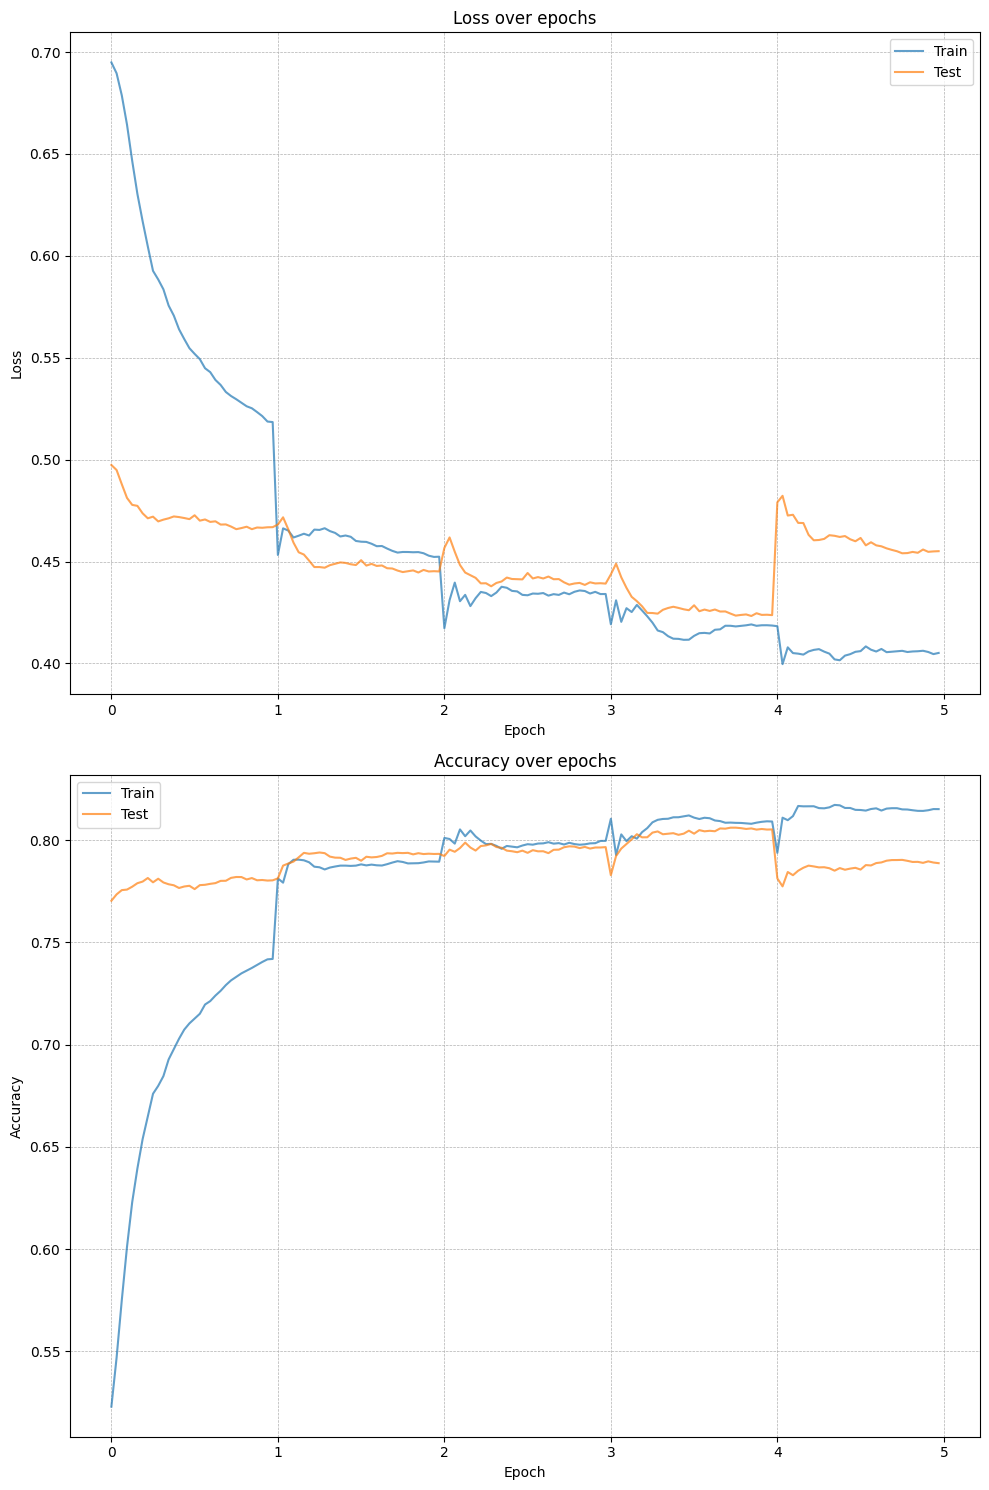

In [ ]:
mlp64 = MLP(state_dim=64).to(device)
mlp64_metrics = train_model(mlp64, train_dataloader, test_dataloader,
                          optimizer=torch.optim.Adam(mlp64.parameters(), lr=0.005),
                          criterion=nn.CrossEntropyLoss(),
                          num_epochs=5)
#torch.save(mlp64, mlp64.name() + '_64'+ ".pth")


Epoch 1/5
Training MLP on cuda:0


Epoch 1/5 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating MLP on cuda:0


Epoch 1/5 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.4973, Train Accuracy: 0.7553
Test Loss: 0.5069, Test Accuracy: 0.7611

Epoch 2/5
Training MLP on cuda:0


Epoch 2/5 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating MLP on cuda:0


Epoch 2/5 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.4309, Train Accuracy: 0.8014
Test Loss: 0.4242, Test Accuracy: 0.8041

Epoch 3/5
Training MLP on cuda:0


Epoch 3/5 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating MLP on cuda:0


Epoch 3/5 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.4088, Train Accuracy: 0.8135
Test Loss: 0.4210, Test Accuracy: 0.8065

Epoch 4/5
Training MLP on cuda:0


Epoch 4/5 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating MLP on cuda:0


Epoch 4/5 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.3968, Train Accuracy: 0.8214
Test Loss: 0.4309, Test Accuracy: 0.8035

Epoch 5/5
Training MLP on cuda:0


Epoch 5/5 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating MLP on cuda:0


Epoch 5/5 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.3789, Train Accuracy: 0.8309
Test Loss: 0.4166, Test Accuracy: 0.8117


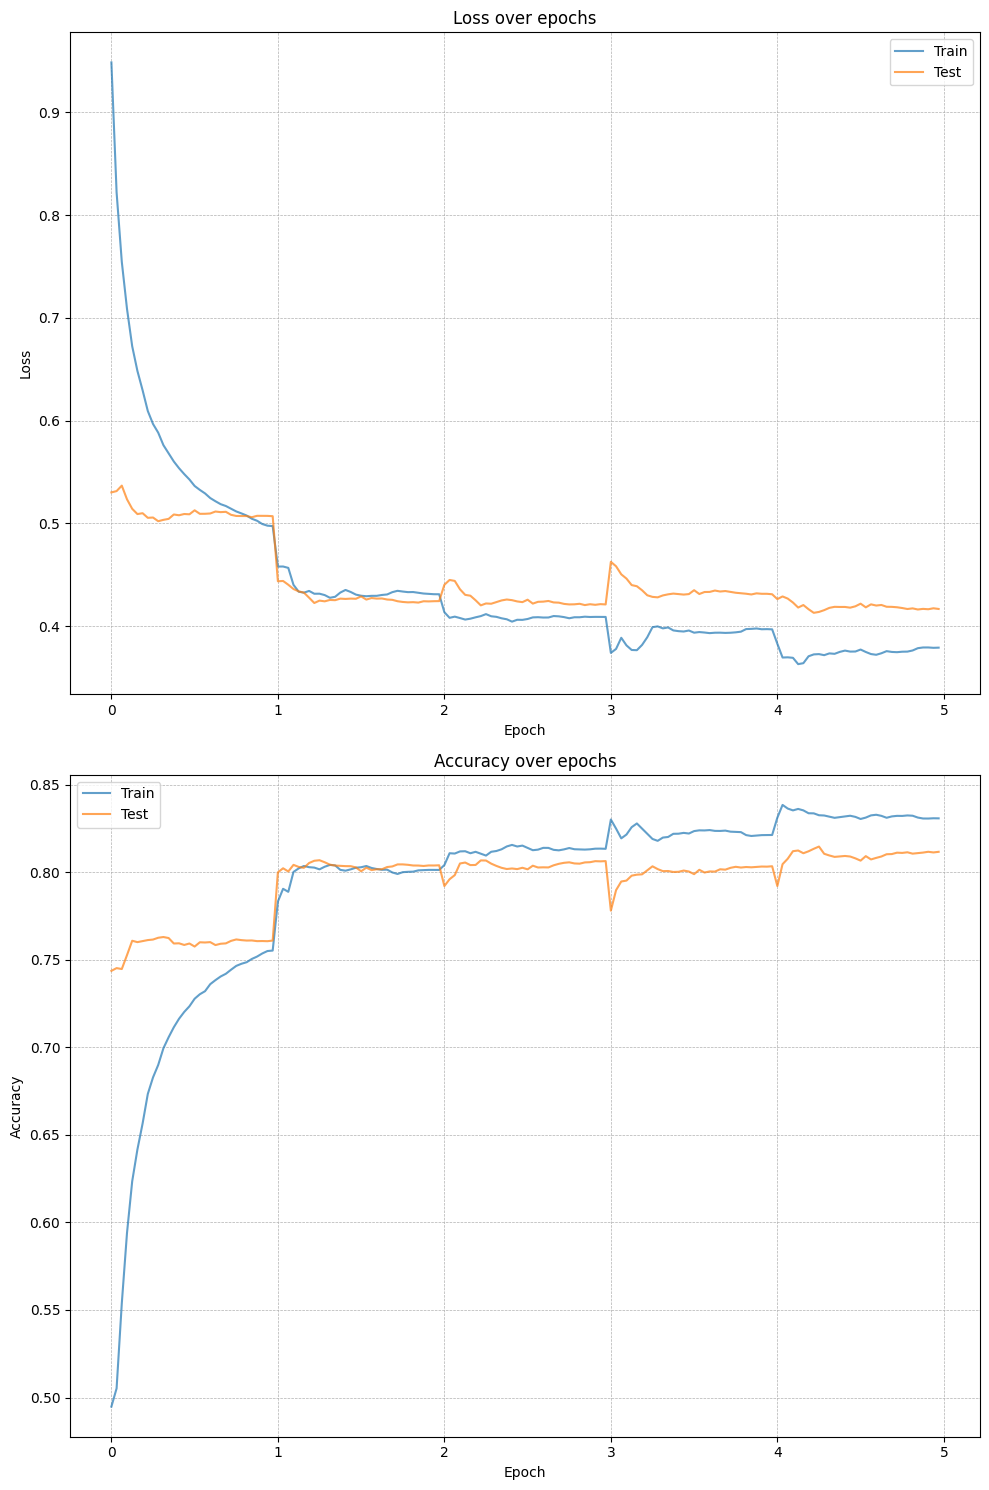

In [ ]:
mlp128 = MLP(state_dim=128).to(device)
mlp128_metrics = train_model(mlp128, train_dataloader, test_dataloader,
                          optimizer=torch.optim.Adam(mlp128.parameters(), lr=0.05),
                          criterion=nn.CrossEntropyLoss(),
                          num_epochs=5)
#torch.save(mlp128, mlp128.name() + '_128'+ ".pth")

# Self Attention

In [ ]:
import math

class MatMul(nn.Module):
    def __init__(self, in_channels, out_channels, use_bias=True):
        super(MatMul, self).__init__()
        self.matrix = torch.nn.Parameter(torch.nn.init.xavier_normal_(torch.empty(in_channels, out_channels)), requires_grad=True)
        if use_bias:
            self.bias = torch.nn.Parameter(torch.zeros(1, 1, out_channels), requires_grad=True)
        self.use_bias = use_bias

    def forward(self, x):
        x = torch.matmul(x, self.matrix)
        if self.use_bias:
            x = x + self.bias
        return x

class RestrictedSelfAttention(nn.Module):
    def __init__(self, feature_dim, state_dim, window_size=5):
        super(RestrictedSelfAttention, self).__init__()
        self.feature_dim = feature_dim
        self.state_dim = state_dim
        self.window_size = window_size
        self.sqrt_state_dim = np.sqrt(float(state_dim))

        self.W_q = MatMul(feature_dim, state_dim, use_bias=False)
        self.W_k = MatMul(feature_dim, state_dim, use_bias=False)
        self.W_v = MatMul(feature_dim, state_dim, use_bias=False)
        self.W_o = MatMul(state_dim, feature_dim, use_bias=False)

        self.layer_norm = nn.LayerNorm(feature_dim)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape

        x = self.layer_norm(x)

        # Compute Q, K, V
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)

        # Prepare padded sequence for restricted attention
        padded_K = F.pad(K, (0, 0, self.window_size, self.window_size), mode='constant', value=0)
        padded_V = F.pad(V, (0, 0, self.window_size, self.window_size), mode='constant', value=0)

        # Initialize output tensor
        output = torch.zeros(batch_size, seq_len, self.state_dim, device=x.device)
        atten_weights = torch.zeros(batch_size, seq_len, 2 * self.window_size + 1, device=x.device)

        for i in range(seq_len):
            # Extract window
            window_K = padded_K[:, i:i+2*self.window_size+1, :]
            window_V = padded_V[:, i:i+2*self.window_size+1, :]

            # Compute attention scores
            attention = torch.matmul(Q[:, i:i+1, :], window_K.transpose(-2, -1)) / self.sqrt_state_dim

            # Apply softmax to get attention weights
            attention_weights = F.softmax(attention, dim=-1)
            atten_weights[:, i, :] = attention_weights.squeeze(1)

            # Compute weighted sum
            weighted_sum = torch.matmul(attention_weights, window_V)
            output[:, i:i+1, :] = weighted_sum

        return output, atten_weights


class PositionalEncoding(nn.Module):
    def __init__(self, model_dim, max_length=5000):
        super(PositionalEncoding, self).__init__()
        self.positional_encoding = self._generate_positional_encoding(model_dim, max_length)
        self.register_buffer('pe', self.positional_encoding)

    def _generate_positional_encoding(self, model_dim, max_length):
        position_encoding = torch.zeros(max_length, model_dim)
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
        div_term = self._get_div_term(model_dim)
        position_encoding[:, 0::2] = torch.sin(position * div_term)
        position_encoding[:, 1::2] = torch.cos(position * div_term)
        return position_encoding.unsqueeze(0)

    def _get_div_term(self, model_dim):
        return torch.exp(torch.arange(0, model_dim, 2).float() * (-math.log(10000.0) / model_dim))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


class SelfAttentionMLP(nn.Module):
    def __init__(self, feature_dim=100, state_dim=64, window_size=5):
        super(SelfAttentionMLP, self).__init__()
        self.positional_encoding = PositionalEncoding(feature_dim)
        self.self_attention = RestrictedSelfAttention(feature_dim, state_dim, window_size)
        self.mlp = self._build_mlp(state_dim)

    def _build_mlp(self, state_dim):
        return nn.Sequential(
            nn.Linear(state_dim, state_dim),
            nn.ReLU(),
            nn.Linear(state_dim, 2)
        )

    def forward(self, x):
        x = self.positional_encoding(x)
        x, attention_weights = self.self_attention(x)
        sub_scores = self.mlp(x)  # (batch_size, seq_len, 2)
        scores = torch.mean(sub_scores, dim=1)  # (batch_size, 2)
        return scores, sub_scores

    def name(self):
        return "SelfAttentionMLP"

    def train_step(self, inputs, targets, optimizer, criterion):
        optimizer.zero_grad()
        logits, _ = self(inputs)
        loss = self._compute_loss(logits, targets, criterion)
        loss.backward()
        optimizer.step()
        return loss.item(), logits

    def validation_step(self, inputs, targets, criterion):
        logits, _ = self(inputs)
        loss = self._compute_loss(logits, targets, criterion)
        return loss.item(), logits

    def _compute_loss(self, logits, targets, criterion):
        return criterion(logits, targets)



Epoch 1/10
Training SelfAttentionMLP on cuda:0


Epoch 1/10 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating SelfAttentionMLP on cuda:0


Epoch 1/10 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.5253, Train Accuracy: 0.7261
Test Loss: 0.5195, Test Accuracy: 0.7443

Epoch 2/10
Training SelfAttentionMLP on cuda:0


Epoch 2/10 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating SelfAttentionMLP on cuda:0


Epoch 2/10 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.4583, Train Accuracy: 0.7813
Test Loss: 0.4550, Test Accuracy: 0.7839

Epoch 3/10
Training SelfAttentionMLP on cuda:0


Epoch 3/10 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating SelfAttentionMLP on cuda:0


Epoch 3/10 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.4349, Train Accuracy: 0.7966
Test Loss: 0.4556, Test Accuracy: 0.7840

Epoch 4/10
Training SelfAttentionMLP on cuda:0


Epoch 4/10 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating SelfAttentionMLP on cuda:0


Epoch 4/10 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.4249, Train Accuracy: 0.8024
Test Loss: 0.4319, Test Accuracy: 0.7978

Epoch 5/10
Training SelfAttentionMLP on cuda:0


Epoch 5/10 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating SelfAttentionMLP on cuda:0


Epoch 5/10 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.4094, Train Accuracy: 0.8106
Test Loss: 0.4261, Test Accuracy: 0.7996

Epoch 6/10
Training SelfAttentionMLP on cuda:0


Epoch 6/10 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating SelfAttentionMLP on cuda:0


Epoch 6/10 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.4017, Train Accuracy: 0.8156
Test Loss: 0.4218, Test Accuracy: 0.8032

Epoch 7/10
Training SelfAttentionMLP on cuda:0


Epoch 7/10 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating SelfAttentionMLP on cuda:0


Epoch 7/10 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.3945, Train Accuracy: 0.8183
Test Loss: 0.4199, Test Accuracy: 0.8035

Epoch 8/10
Training SelfAttentionMLP on cuda:0


Epoch 8/10 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating SelfAttentionMLP on cuda:0


Epoch 8/10 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.3870, Train Accuracy: 0.8255
Test Loss: 0.4162, Test Accuracy: 0.8078

Epoch 9/10
Training SelfAttentionMLP on cuda:0


Epoch 9/10 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating SelfAttentionMLP on cuda:0


Epoch 9/10 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.3770, Train Accuracy: 0.8285
Test Loss: 0.4219, Test Accuracy: 0.8032

Epoch 10/10
Training SelfAttentionMLP on cuda:0


Epoch 10/10 [Train]:   0%|          | 0/469 [00:00<?, ?it/s]

Evaluating SelfAttentionMLP on cuda:0


Epoch 10/10 [Eval]:   0%|          | 0/313 [00:00<?, ?it/s]

Train Loss: 0.3714, Train Accuracy: 0.8317
Test Loss: 0.4233, Test Accuracy: 0.8050


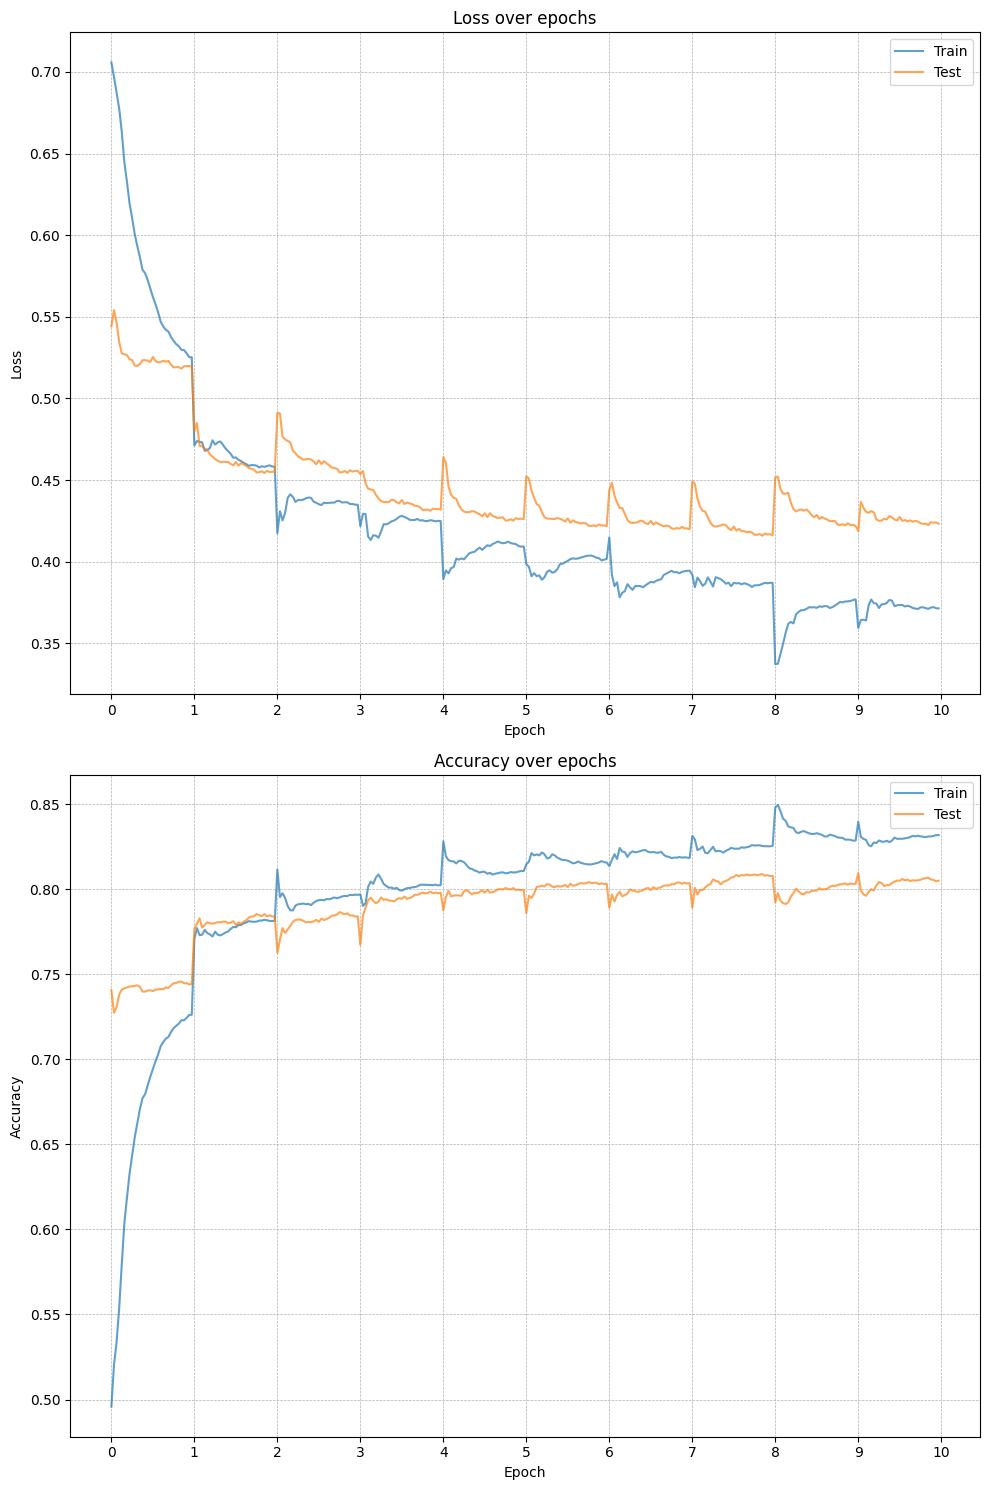

In [ ]:
# Create and train the model
self_attention_mlp = SelfAttentionMLP(state_dim=128).to(device)
self_attention_mlp_metrics = train_model(self_attention_mlp, train_dataloader, test_dataloader,
                                         optimizer=torch.optim.Adam(self_attention_mlp.parameters(), lr=0.001),
                                         criterion=nn.CrossEntropyLoss(),
                                         num_epochs=10)


In [ ]:
#torch.save(self_attention_mlp, self_attention_mlp.name() + '_128'+ ".pth")

In [ ]:
held_out_reviews.append("Great plot but overrated.")

In [ ]:
held_out_reviews

['This movie was amazing, truly a masterpiece!',
 'I enjoyed every moment of this fantastic film.',
 'The actors delivered outstanding performances, loved it.',
 'Great storyline and excellent direction, highly recommend it.',
 "I wasn't looking forward to watching the film. I was surprised I enjoyed it very much.",
 'This movie was boring and uninteresting.',
 'I did not enjoy the film at all.',
 'Terrible acting and weak storyline, very disappointing.',
 'Poor direction and lackluster performances, avoid it.',
 'it is hard being that good in being so bad.',
 'Great plot but overrated.']

# test models

In [ ]:
# Load the trained MLP model
model = torch.load("/content/MLP_64.pth", map_location=device)
model.eval()

# Process the held-out reviews and get predictions
sent_list = []
for s in held_out_reviews:
    preprocessed_review = loader.preprocess_review(s)
    preprocessed_review = preprocessed_review.to(device)
    preprocessed_review = preprocessed_review.unsqueeze(0)  # Add batch dimension if necessary

    with torch.no_grad():
        output, _ = model(preprocessed_review)
        # Separate positive and negative scores
        positive_scores = output[:, :, 0]
        negative_scores = output[:, :, 1]

        # Aggregate scores (e.g., by summing or averaging)
        total_positive_score = positive_scores.sum()
        total_negative_score = negative_scores.sum()

        # Determine overall sentiment
        sentiment = 'pos' if total_positive_score > total_negative_score else 'neg'
        sent_list.append(sentiment)
# Print the sentiment predictions
print(sent_list)

['pos', 'pos', 'pos', 'pos', 'pos', 'neg', 'pos', 'neg', 'neg', 'pos', 'pos']


In [ ]:
# Load the trained MLP model
model = torch.load("/content/MLP_128.pth", map_location=device)
model.eval()

# Process the held-out reviews and get predictions
sent_list = []
for s in held_out_reviews:
    preprocessed_review = loader.preprocess_review(s)
    preprocessed_review = preprocessed_review.to(device)
    preprocessed_review = preprocessed_review.unsqueeze(0)  # Add batch dimension if necessary

    with torch.no_grad():
        output, _ = model(preprocessed_review)
        # Separate positive and negative scores
        positive_scores = output[:, :, 0]
        negative_scores = output[:, :, 1]

        # Aggregate scores (e.g., by summing or averaging)
        total_positive_score = positive_scores.sum()
        total_negative_score = negative_scores.sum()

        # Determine overall sentiment
        sentiment = 'pos' if total_positive_score > total_negative_score else 'neg'
        sent_list.append(sentiment)
# Print the sentiment predictions
print(sent_list)

['pos', 'pos', 'pos', 'pos', 'pos', 'neg', 'pos', 'neg', 'neg', 'pos', 'pos']


In [ ]:
# Load the trained MLP model
model = torch.load("/content/SelfAttentionMLP_128.pth", map_location=device)
model.eval()
# Process the held-out reviews and get predictions
sent_list = []
for s in held_out_reviews:
  embedding_tensor = loader.preprocess_review(s)

  # Move tensor to the appropriate device
  embedding_tensor = embedding_tensor.to(device)

  with torch.no_grad():
      # Ensure input tensor is of the correct shape
      if embedding_tensor.dim() == 2:
          embedding_tensor = embedding_tensor.unsqueeze(0)  # Add batch dimension

      # Get model output
      logits, _ = model(embedding_tensor)

  # Convert logits to predictions
  predictions = torch.argmax(logits, dim=1).cpu().numpy()

  # Map predictions to labels
  labels = ['pos', 'neg']
  sent_list.append(labels[predictions[0]])
sent_list

['pos', 'pos', 'pos', 'pos', 'pos', 'neg', 'pos', 'neg', 'neg', 'pos', 'neg']